In [31]:
import argparse
import tensorflow as tf
import skimage as skio
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2 as cv
from __future__ import print_function
from tensorflow.keras import datasets, layers, models



Image extraction

In [11]:

#Function able to detect faces within an image
def detectAndDisplay(frame):
    im = []
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        im.append(frame[y:y+h,x:x+w])
        frame = cv.rectangle(frame, (x,y), (x+w, y+h),(0, 0, 0), 0)
        faceROI = frame_gray[y:y+h,x:x+w]
    return(frame,im)
#Given cascade
path = open("path.txt", "r").read()
face_cascade = cv.CascadeClassifier(path)

In [12]:

#Images from the twitter api
n=0
list_test = os.listdir('./twitter')
for it,i in enumerate(list_test):
    try:
        img = plt.imread('./twitter/{}'.format(list_test[it]))
        m = detectAndDisplay(img)
        
        for it1,i1 in enumerate(m[1]):
            plt.imsave('face/{}'.format(list_test[it].replace('.jpg',''))+str(it1)+'.jpg',i1)
    except:
        'no face'




In [29]:
#Faces extracted from all the images from twitter api
list_test = os.listdir('./face')
test_mine = np.zeros((len(list_test),48,48,1))
for it,i in enumerate(list_test):
    img = cv2.resize(plt.imread('./face/{}'.format(list_test[it])),(48,48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    test_mine[it,:,:,0]= img


In [14]:
#List all the emotions in the dataset
list_emotion = np.array(os.listdir('./images/train'))[[0,2,3,4,5,6]]
n = list_emotion.shape[0]

#Extract images for each emotion at stake
LIST = []
for it,i in enumerate(list_emotion):
    LIST.append(os.listdir('./images/train/{}'.format(i))[:3000])
nb_emotion = list(map(len,LIST))
images = np.zeros((sum(nb_emotion),48,48,1))
temp=0
for it,i in enumerate(LIST):
    for jt,j in enumerate(LIST[it]):
        images[temp,:,:,0]= plt.imread('./images/train/{}/{}'.format(list_emotion[it],j))
        temp+=1


# Normalize pixel values to be between 0 and 1
images = images / 255.0

In [18]:
train_labels = np.array([i  for i in range(len(list_emotion))for j in range(nb_emotion[i])])
train_labels = np.zeros((3000*n,n))
for it,i in enumerate(train_labels):
    train_labels[it,it//3000]=1
len(train_labels)

18000

In [19]:
list_emotion

array(['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(images, train_labels, test_size=0.1, random_state=42)

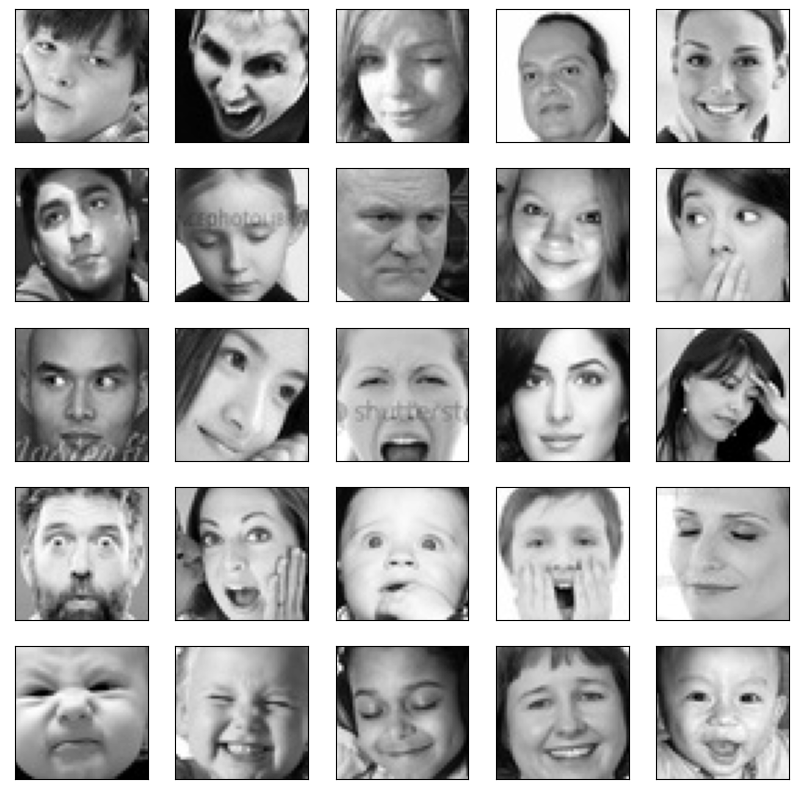

In [25]:
plt.figure(figsize=(10,10))
rand = np.random.choice(len(images),25,replace = False)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[rand[i],:,:,0],cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

CNN for emotion classification (Implementation)

In [26]:
class Classifier:
    def __init__(self):
        self.model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(48, 48, 1)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(n, activation="softmax")]

)
    def train(self,train_images, train_labels,test_images, test_labels,optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy']):
        self.model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
        self.model.fit(train_images, train_labels, epochs=15, 
                        validation_data=(test_images, test_labels))


In [27]:
Clas = Classifier()
Clas.train(X_train,y_train, X_test, y_test)

Epoch 1/15
507/507 [==============================] - 39s 74ms/step - loss: 1.7010 - accuracy: 0.2882 - val_loss: 1.8349 - val_accuracy: 0.2422
Epoch 2/15
507/507 [==============================] - 46s 92ms/step - loss: 1.4651 - accuracy: 0.4037 - val_loss: 1.5102 - val_accuracy: 0.4117
Epoch 3/15
507/507 [==============================] - 45s 89ms/step - loss: 1.3665 - accuracy: 0.4486 - val_loss: 1.3773 - val_accuracy: 0.4633
Epoch 4/15
507/507 [==============================] - 44s 87ms/step - loss: 1.2804 - accuracy: 0.4910 - val_loss: 1.4594 - val_accuracy: 0.4578
Epoch 5/15
507/507 [==============================] - 44s 87ms/step - loss: 1.2120 - accuracy: 0.5240 - val_loss: 1.4252 - val_accuracy: 0.4550
Epoch 6/15
507/507 [==============================] - 68s 134ms/step - loss: 1.1355 - accuracy: 0.5512 - val_loss: 1.4170 - val_accuracy: 0.4494
Epoch 7/15
507/507 [==============================] - 50s 98ms/step - loss: 1.0472 - accuracy: 0.5926 - val_loss: 1.3903 - val_accuracy

1/1 [==============================] - 0s 35ms/step


C:\Users\cmbbd\AppData\Local\Temp\ipykernel_936\2067867905.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


1/1 [==============================] - 0s 35ms/step


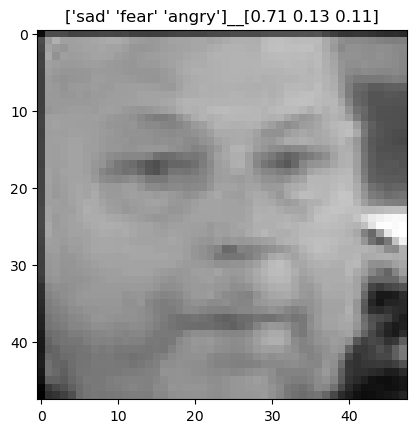

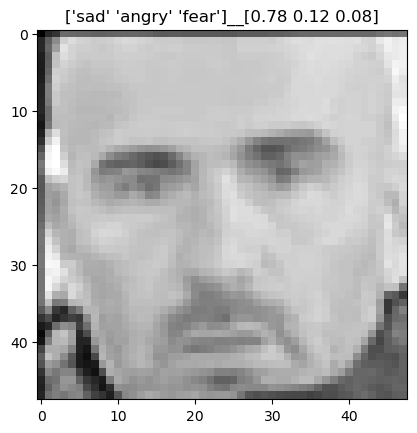

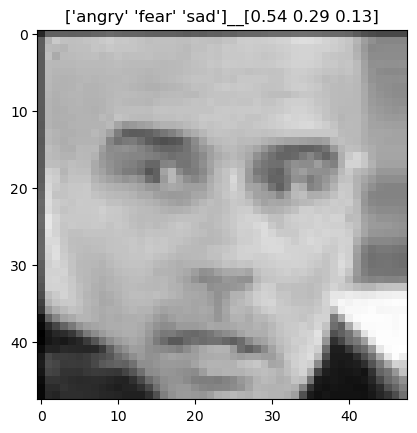

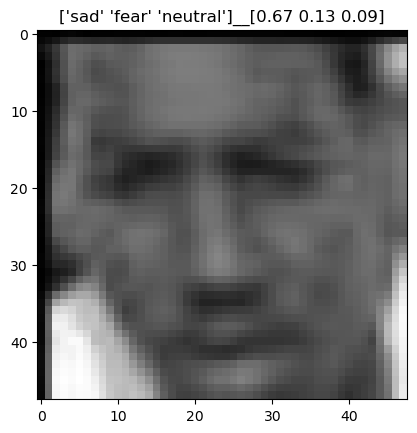

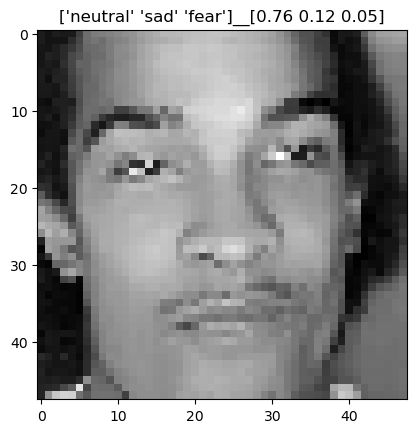

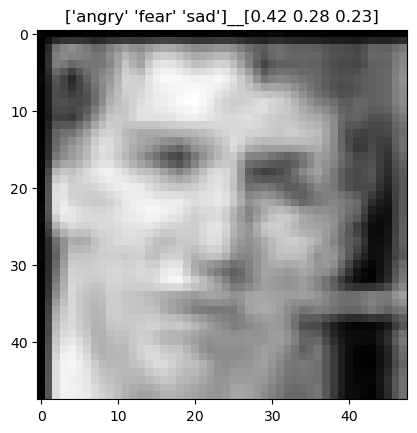

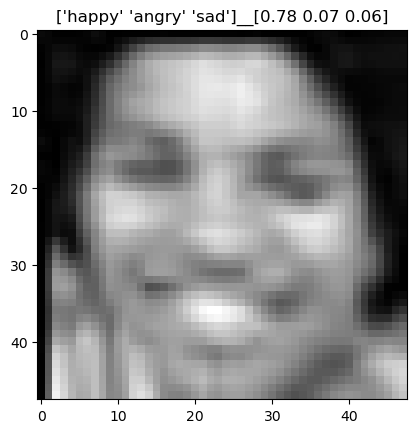

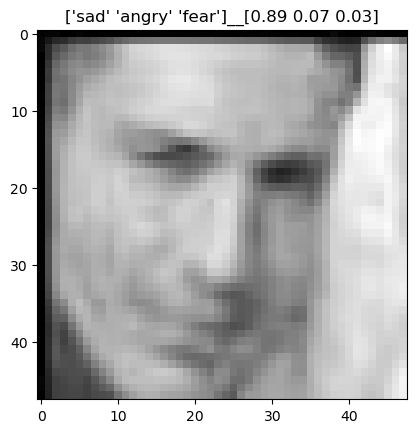

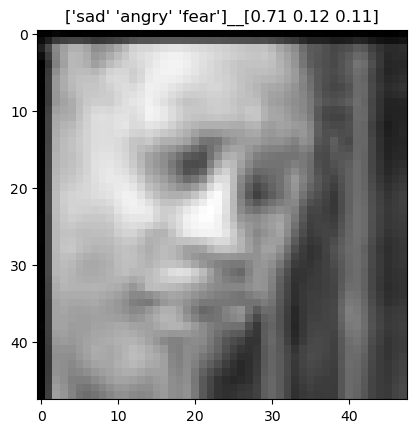

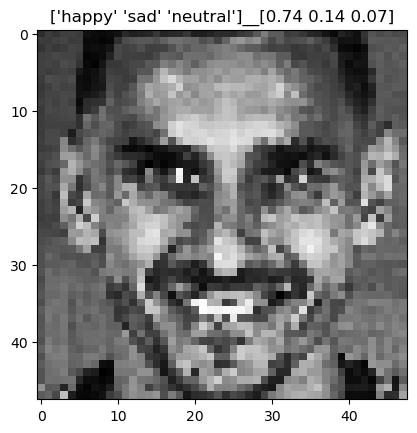

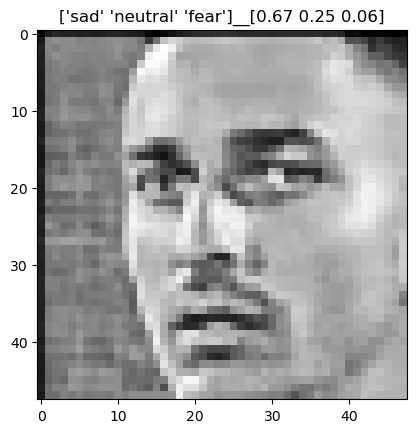

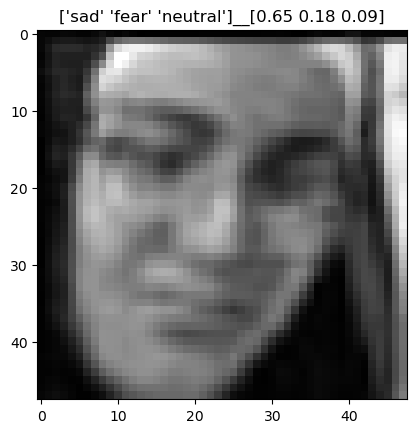

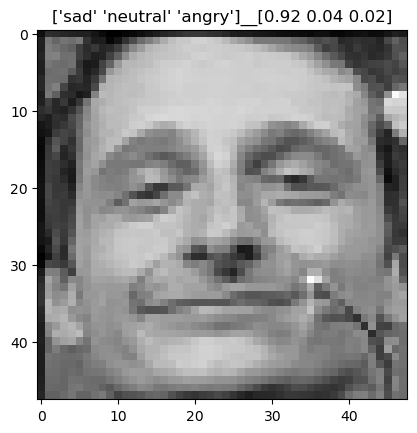

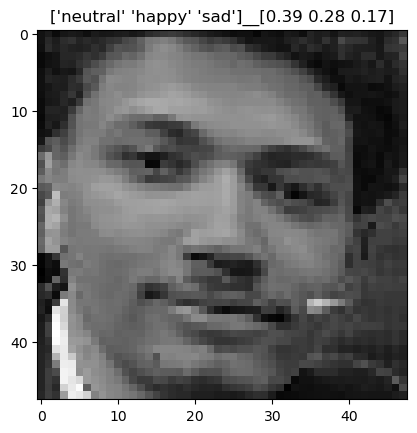

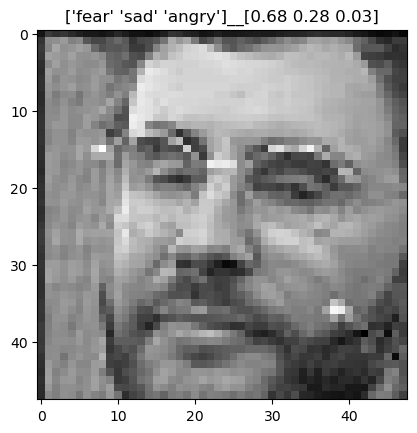

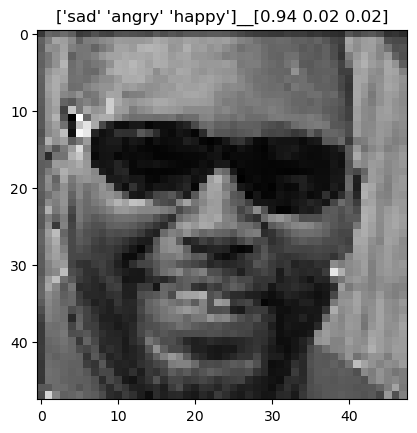

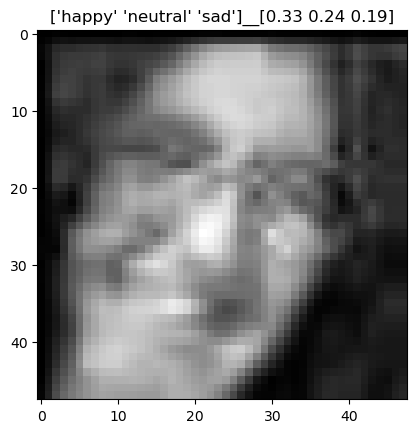

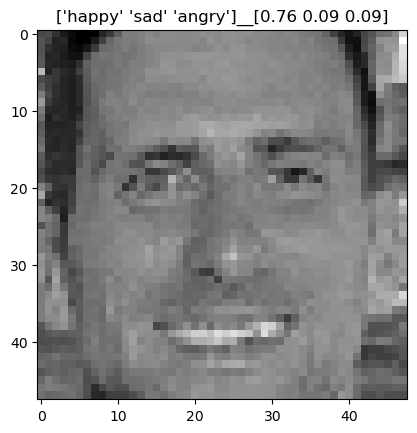

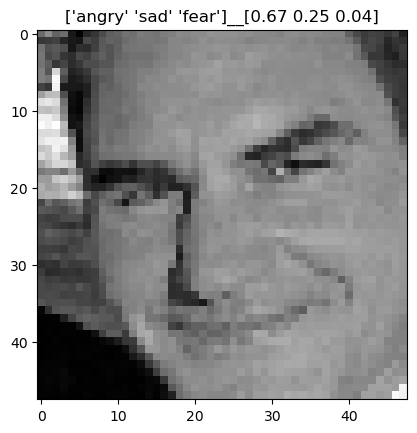

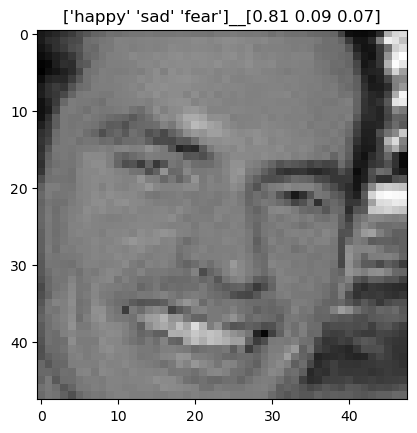

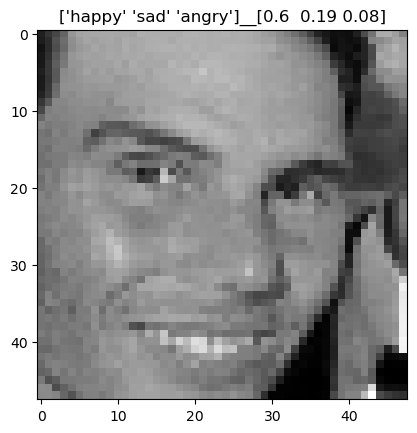

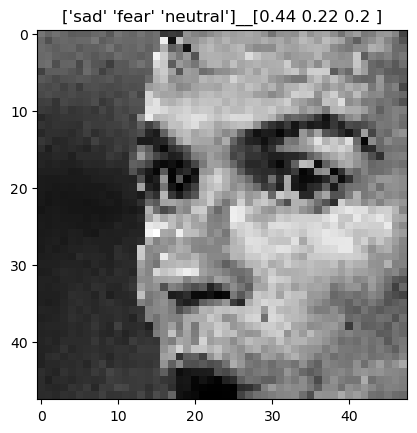

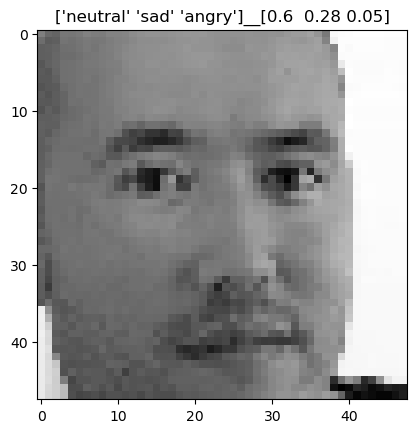

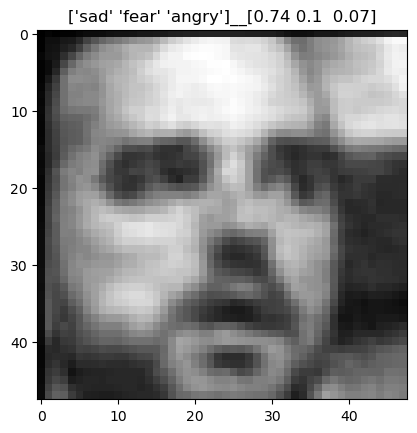

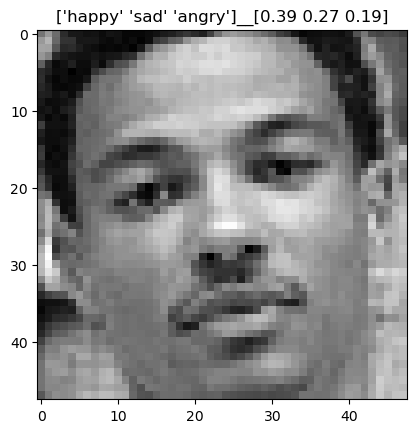

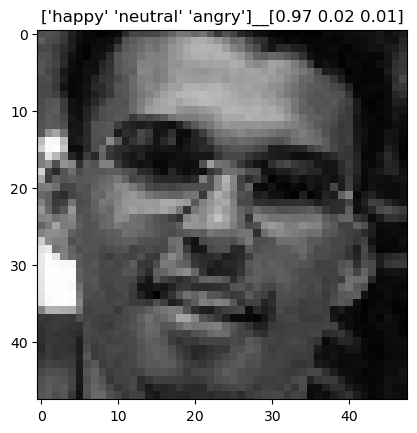

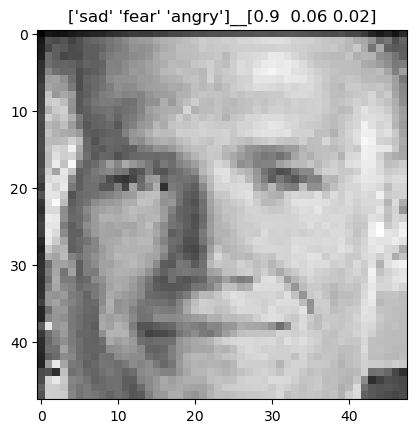

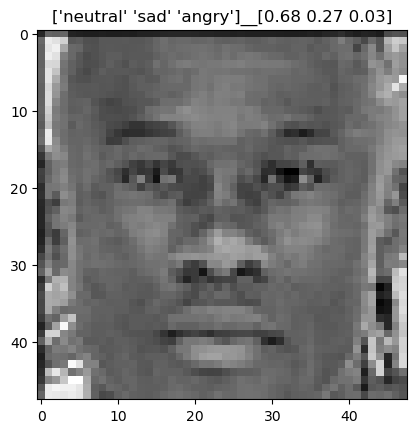

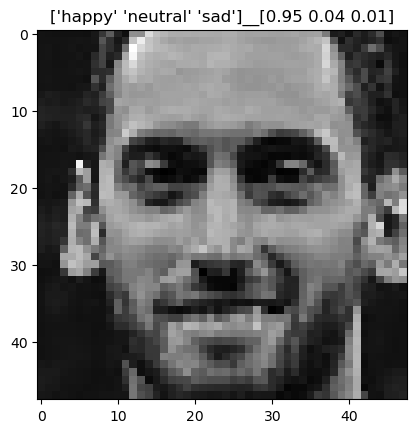

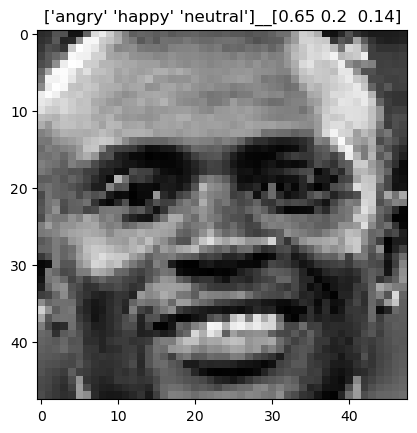

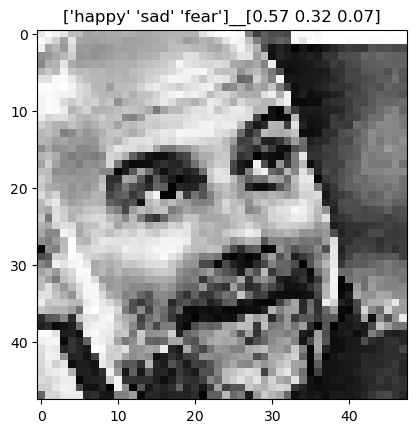

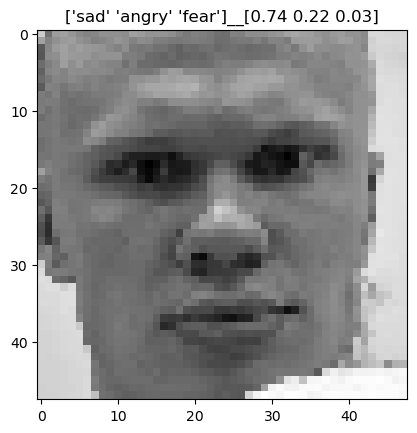

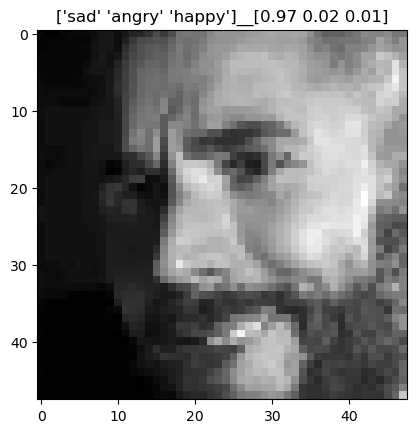

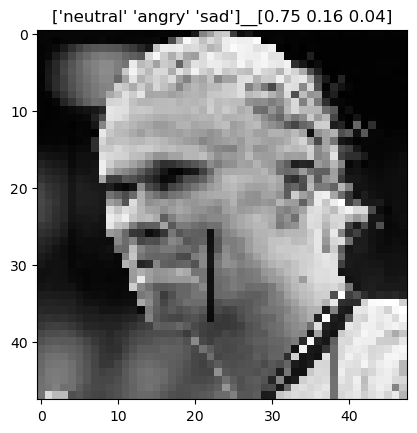

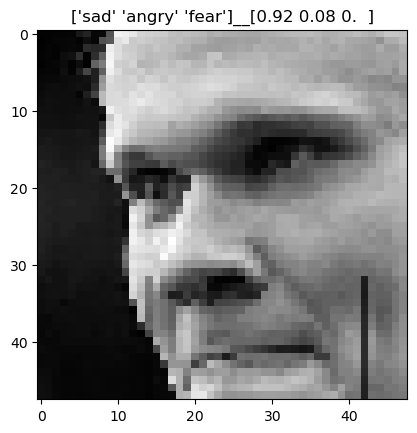

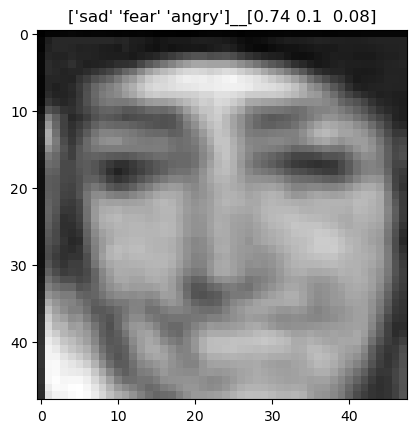

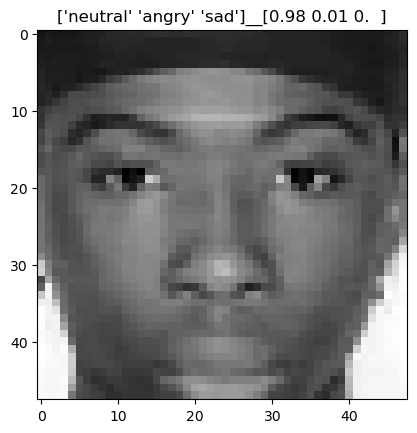

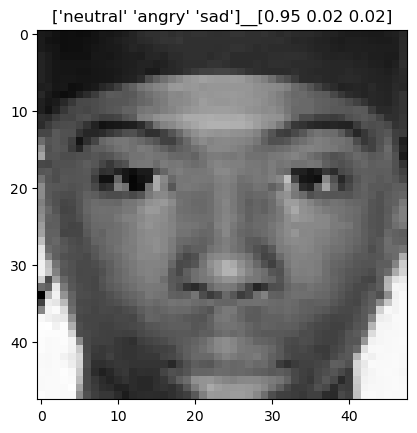

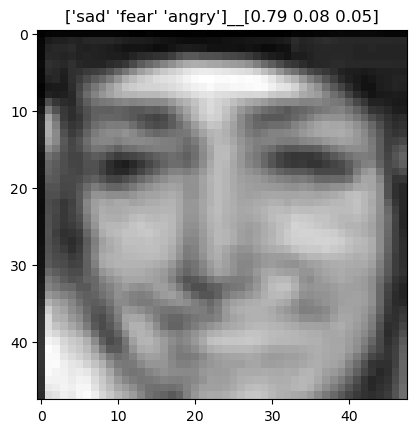

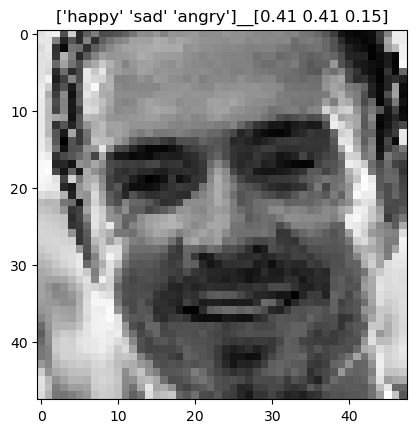

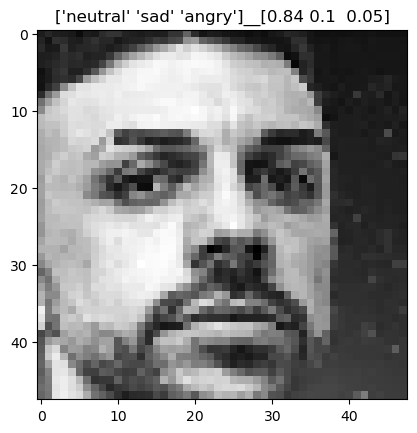

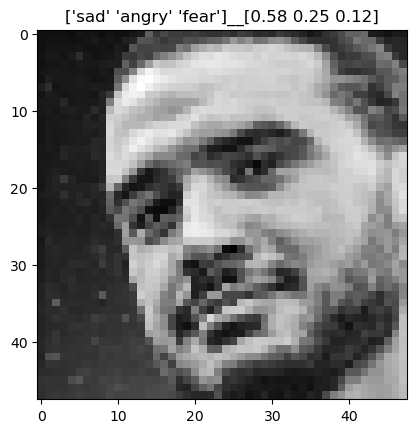

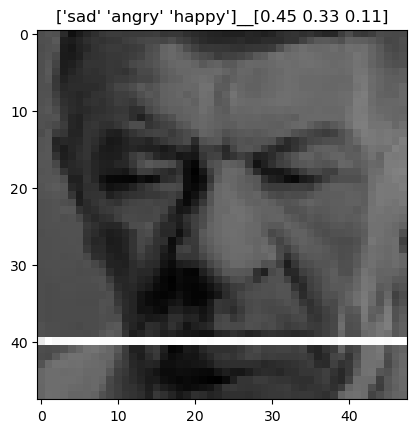

<Figure size 640x480 with 0 Axes>

In [30]:
for it,i in enumerate(test_mine):
    plt.imshow(i,cmap='gray')
    plt.title(str(list_emotion[np.argsort(Clas.model.predict(np.array([i])))[0][[-1,-2,-3]]])+'__'+str(np.round(np.sort(Clas.model.predict(np.array([i])))[0][[-1,-2,-3]],2)))
    plt.figure()

In [160]:
np.argsort(Clas.model.predict(np.array([i])))[0][[-1,-2,-3]]

1/1 [==============================] - 0s 37ms/step


array([4, 2, 1], dtype=int64)